In [481]:
import sys
import os
import empyrical
import numpy as np
import pandas as pd
import configparser
import alphalens as al
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
sys.path.append('/Users/apple/Documents/Github/SHANFOLIO')
from shanf.datakit.DtLoader import DtLoader
from shanf.apt.Factor import Factor,IndexComp_Factor
from scripts import stats_utils as su
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
config = configparser.ConfigParser()
config.read('../../config.ini')
data_path = config.get('path', 'data_path')

In [4]:
def convert_symbol(df, col):
    df[col] = df[col].astype(str).apply(lambda x: x.zfill(6))
    return df

index_comp_df = pd.read_csv('/Users/apple/Documents/qsquant/index_comp.csv',encoding='gbk')
index_basic_info = pd.read_csv('/Users/apple/Documents/qsquant/TQ_IX_BASICINFO.csv', encoding='gbk')

index_comp_df.columns = index_comp_df.columns.str.lower()
index_basic_info.columns = index_basic_info.columns.str.lower()

index_comp_df = convert_symbol(index_comp_df, 'symbol')
index_comp_df = convert_symbol(index_comp_df, 'selectesymbol')
index_basic_info = convert_symbol(index_basic_info, 'symbol')

In [5]:
tradeassets = index_basic_info.loc[index_basic_info['estclass']=='申万一级行业指数']['symbol'].tolist()

In [6]:
index_comp_dict = {}
for symbol,group in index_comp_df.groupby('symbol')['selectesymbol']:
    if symbol in tradeassets:
        index_comp_dict[symbol] = group.tolist()

In [7]:
stock_fl = DtLoader(field_root=os.path.join(data_path, 'processed/stock'))
index_fl = DtLoader(field_root=os.path.join(data_path, 'processed/index'))


Factor.set_fl(stock_fl)
IndexComp_Factor.set_index_comp_dict(index_comp_dict)

In [8]:
bm_prices = index_fl.close.loc[:, '000985']
bm_prices = bm_prices.replace({0:np.nan})
bm_ret = bm_prices.pct_change()

prices = index_fl.close.loc[:, tradeassets]
prices = prices.replace({0:np.nan})
prices = prices.ffill()
ret = prices.pct_change()

pre_ret = ret.sub(bm_ret, axis=0)

### Market Breadth

In [10]:
class MB(IndexComp_Factor):
    
    def calculate(self,**kwargs):
        
        mb = pd.DataFrame(index =  IndexComp_Factor.fl.__getattr__(kwargs['name']).index, columns = IndexComp_Factor.tradeassets)
        val = IndexComp_Factor.fl.__getattr__(kwargs['name'])
        val = self.prevent_0(val).ffill()
        
        if kwargs['rank'] == True:
            val = val.rank(axis=1)
        
        for sec,group in IndexComp_Factor.index_comp_dict.items():
            group  = [i for i in group if i in  val.columns.tolist()]
            val_comp = val.loc[:,group]
            
            if kwargs['method'] == 'ma':
                adv_criteria = val_comp - val_comp.rolling(kwargs['period']).mean()
                dcl_criteria = val_comp.rolling(kwargs['period']).mean() - val_comp
                
            if kwargs['method'] == 'net high':
                adv_criteria = val_comp - val_comp.rolling(kwargs['period']).max()
                dcl_criteria = val_comp.rolling(kwargs['period']).min() - val_comp 
                
            if kwargs['method'] == 'adv':
                adv_criteria = val_comp - val_comp.shift(kwargs['period'])
                dcl_criteria = val_comp.shift(kwargs['period']) - val_comp
            
            advancing = np.where(adv_criteria > 0, 1, np.where(adv_criteria<0, 0,np.nan))
            declining = np.where(dcl_criteria > 0, 1, np.where(dcl_criteria>0, 0,np.nan))

            
            # Market Breadth Calculation
            advancing_sum = np.nansum(advancing, axis = 1)
            declining_sum = np.nansum(declining, axis = 1)
            notna_sum = np.count_nonzero(~np.isnan(advancing), axis = 1)
            
            # Market Breadth Ratio
            if kwargs['breadth_method']  == 'total':
                mb.loc[:,sec] = advancing_sum/(notna_sum)
            if kwargs['breadth_method']  == 'net':
                mb.loc[:,sec] = (advancing_sum/declining_sum)
            
        return mb

### Combine sig

## 策略种类

- Dual Trust
- Reverse


In [13]:
def filter_factor(x,d):
    return pd.DataFrame(np.where(x>d,1,np.where(x<-d,-1,0)),index = x.index,columns=x.columns)

def get_corr(ret,sig,isp=True):
    if isp:
        sig = sig.loc['2016-01-01':'2021-01-01']
        ret = ret.loc['2016-01-01':'2021-01-01']
    elif isp == False:
        sig = sig.loc['2021-01-01':'2023-01-01']
        ret = ret.loc['2021-01-01':'2023-01-01']
    elif isp is None:
        sig = sig.loc['2016-01-01':'2023-01-01']
        ret = ret.loc['2016-01-01':'2023-01-01']
    
    idx = sig.index.intersection(ret.index)
    sig = sig.loc[idx]
    ret = ret.loc[idx]
    
    stg_ret = sig * np.array(ret)
    
    log_ret = np.log(1+ret)
    
    ann_ret,sharpe,calmar,max_dd,win_ratio_day = [],[],[],[],[]
    for col in sig.columns:
        _stg_ret = stg_ret[col]
        _ann_ret = empyrical.annual_return(_stg_ret, period='daily')
        _sharpe = empyrical.sharpe_ratio(_stg_ret, period='daily')  
        _calmar = empyrical.calmar_ratio(_stg_ret) 
        _max_dd = empyrical.max_drawdown(_stg_ret)  
        _win_ratio_day = np.where(_stg_ret>0,1,0).sum() / (np.where(_stg_ret>0,1,0).sum() + np.where(_stg_ret<0,1,0).sum())

        ann_ret.append(_ann_ret)
        sharpe.append(_sharpe)
        calmar.append(_calmar)
        max_dd.append(_max_dd)
        win_ratio_day.append(_win_ratio_day)
        
    
    corr = log_ret.corrwith(sig,axis=0,method='spearman')
    
        
    return {
            'corr':corr.mean(),
            'ann_ret':np.mean(ann_ret),
            'sharpe':np.mean(sharpe),
            'calmar':np.mean(calmar),
            'max_dd':np.mean(max_dd),
            'win_ratio_day':np.mean(win_ratio_day)
            }

## 策略方法


- MB type: 
    - MA MB: N日均线以上的个股比例，200日最佳

- 双均线择时：
    - 双均线, MA_Fast>MA_SLOW
    - 二次均线, MA_Fast > MA_FAST_MA_SLOW

In [14]:
df = pd.DataFrame(columns=['corr','ann_ret','sharpe','max_dd','win_ratio_day','type'])
for period in [200,60,120]:
    
    mb1 = MB().calculate(name='roe_fcst',method='ma',period=period,breadth_method='total')
    
    for i in [1,2,3,4,5]:

        for fast in [1,5,10,20,30,60,120,200]:
            for slow in [1,5,10,20,30,60,120,200]:
                if fast >= slow:
                    continue
                
                dual_ma = mb1.rolling(fast).mean() - mb1.rolling(fast).mean().rolling(slow).mean()
                mean =  mb1.rolling(fast).mean()
                
                if i == 1:
                    temp_factor = dual_ma
                    
                elif i == 2:
                    relative_place = ((mean<0.8)).astype(bool).astype(int)
                    temp_factor =relative_place * dual_ma
                    
                elif i == 3:
                    relative_place = ((dual_ma.diff()>0)).astype(bool).astype(int)
                    temp_factor =relative_place*dual_ma
                    
                elif i == 4:
                    relative_place = ((dual_ma.diff()>0)&(dual_ma.diff().diff()>0)).astype(bool).astype(int)
                    temp_factor =relative_place*dual_ma
                    
                elif i == 5:
                    relative_place = ((dual_ma.diff()<0)&(dual_ma.diff().diff()<0)).astype(bool).astype(int)
                    temp_factor =relative_place*dual_ma
                
                sig = filter_factor(temp_factor,0.0)

                corr_isp = get_corr(pre_ret.shift(-1),sig,isp=None)
                corr_isp.update({'type':'all'})
                corr_isp = pd.DataFrame.from_dict(corr_isp, orient='index').T

                df.loc[f'{period}_{i}_{fast}_{slow}'] = corr_isp.iloc[0]

KeyError: 'rank'

In [50]:
print('vwap')
df.sort_values('corr',ascending=False).head(10)

vwap


,corr,ann_ret,sharpe,max_dd,win_ratio_day,type
60_4_5_20,0.00962,-0.000723,0.014227,-0.209149,0.505813,all
120_4_30_200,0.009521,0.000225,0.050706,-0.202229,0.514732,all
120_4_60_200,0.008236,-0.004188,-0.008495,-0.21158,0.51168,all
60_2_1_20,0.008081,-0.002011,0.080868,-0.359838,0.501045,all
200_2_5_20,0.007863,-0.009734,0.034779,-0.394224,0.49413,all
60_3_1_60,0.007832,-0.003416,0.057789,-0.293967,0.505513,all
60_1_1_20,0.007754,-0.002376,0.082428,-0.363234,0.500932,all
60_4_5_30,0.00775,-0.003532,-0.006254,-0.22005,0.50278,all
60_3_1_120,0.007681,-0.005465,0.01889,-0.300888,0.502451,all
200_1_5_20,0.007554,-0.008975,0.039935,-0.393822,0.49425,all


NameError: name 'mb1' is not defined

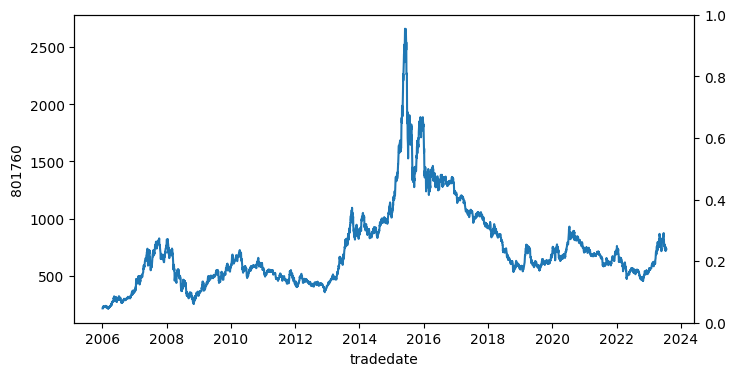

In [12]:
fig,ax = plt.subplots(figsize=(8,4))
# sns.lineplot(pre_ret['801170'])
# sns.lineplot(mb1['801760'].rolling(5).mean())

# sns.lineplot(mb1['801760'].rolling(60).mean())

sns.lineplot(prices['801760'])

ax2 = ax.twinx()

# dea = (mb1['801760'].rolling(5).mean() - mb1['801760'].rolling(60).mean()).rolling(5).sum()
dea = mb1['801760'].rolling(5).mean().diff()

sns.lineplot(dea,color='grey')
sns.lineplot(dea,color='grey')


In [17]:
corr_df = pd.DataFrame(columns = ['corr','ann_ret','calmar','sharpe','max_dd','win_ratio_day','p1','p2','method','breadth_method','period'])


for method in ['ma']:
    print(method)
    for breadth_method in ['total']:
        for period in [200]:
            
            mb1 = MB().calculate(name='close',method=method,period=period,breadth_method=breadth_method)
            
            for p1 in [3,5,10,20,30,40,50,60]:
                for p2 in [5,20,40,60,90,120,160,180,250]:
                    
                    dual_ma= mb1.rolling(p1,min_periods=p1).mean()/mb1.rolling(p1,min_periods=p1).mean().rolling(p2,min_periods=p2).mean() - 1
                    sig = filter_factor(dual_ma,0.0)
                    corr_isp = get_corr(pre_ret.shift(-1),sig,isp=False)
                    # corr_osp = get_corr(pre_ret,sig,isp=False)
                    corr_isp.update({'p1':p1,'p2':p2,'method':method,'breadth_method':breadth_method,'period':period})             
                    
                    corr_isp_df = pd.DataFrame.from_dict(corr_isp, orient='index').T

                    # Assign column names to the DataFrame
                    corr_isp_df.columns = corr_df.columns

                    # Concatenate the DataFrames
                    corr_df = pd.concat([corr_df, corr_isp_df],axis=0)

ma


KeyError: 'rank'

In [15]:
def transform_to_factor_data(mb):
    mb.index = mb.index.tz_localize(None)
    mb = mb.asfreq(None)
    mb = mb.stack()
    mb.index.names = ['date', 'asset']
    
    return mb

In [16]:
mb1 = transform_to_factor_data(mb)

NameError: name 'mb' is not defined

In [388]:
prices.index.name = 'date'
prices.columns.name = 'asset'

prices = prices.loc[prices['801760'].dropna().index]
prices = prices.ffill()

In [18]:
def get_future_ret_list(prices,list_shifts=range(-20,21)):
    
    # Events Ret time series
    
    def get_future_ret(prices, shift):
        series= prices.pct_change().shift(-shift).stack()
        return series

    ret_list = []
    for shift in list_shifts:
        ret_series = get_future_ret(prices, shift)
        ret_list.append(ret_series)
        
    future_ret = pd.concat([prices.stack()]+ret_list,join='outer',axis=1)
    future_ret.columns = ['price']+[ f'ret_{i}' for i in list_shifts]
    
    return future_ret

def get_future_cum_ret_list(prices,list_shifts=[-60,-20,-10,-5,-1,1,5,10,20,60]):
    
    # Triggered future returns
    
    def get_cum_ret(prices,shift):
        series= prices.pct_change(abs(shift)).shift(-shift).stack()
        return series
    
    cum_ret_list = []
    for shift in list_shifts:
        ret_series = get_cum_ret(prices,shift)
        cum_ret_list.append(ret_series)
        
    future_cum_ret = pd.concat([prices.stack()]+cum_ret_list,join='outer',axis=1)
    future_cum_ret.columns = ['price']+[ f'cum_ret_{i}' for i in list_shifts]
    
    return future_cum_ret

def get_event_ret_df(events, future_ret,future_cum_ret):
    
    events_ret = [events]
    events_ret.append(future_ret)
    events_ret = pd.concat(events_ret,join='inner', axis=1).iloc[:,1:]
    
    events_cum_ret = [events]
    events_cum_ret.append(future_cum_ret)
    events_cum_ret = pd.concat(events_cum_ret, join = 'inner',axis=1).iloc[:,1:]
    
    return events_ret, events_cum_ret

In [19]:
def get_event_stats(events_cum_ret):
    event_stats = pd.DataFrame(index = [1,5,10,20,60], columns =['before_ret','after_ret','diff','tval','long_win_ratio','short_win_ratio'])
    
    events_cum_ret = events_cum_ret.dropna(how='any',axis=0)
    
    for i in [1,5,10,20,60]:
        before_event_ret = events_cum_ret[f'cum_ret_{-i}']
        after_event_ret = events_cum_ret[f'cum_ret_{i}']
        
        diff = (after_event_ret - before_event_ret).mean()
        t_value = stats.ttest_rel(after_event_ret, before_event_ret).statistic
        
        long_win_ratio = len(events_cum_ret[events_cum_ret[f'cum_ret_{i}'] > 0]) / len(events_cum_ret)
        short_win_ratio = len(events_cum_ret[events_cum_ret[f'cum_ret_{i}'] < 0]) / len(events_cum_ret)
        
        event_stats.loc[i] = [before_event_ret.mean(), after_event_ret.mean(), diff, t_value, long_win_ratio, short_win_ratio]
    
    event_stats = event_stats.astype(float)
    return (event_stats).round(4)

In [20]:
def get_my_corr_df(pre_corr_isp, corr_isp, base_isp, pre_corr_oop, corr_oop, base_oop):
    my_corr_df = pd.DataFrame(index = ['corr','ann_ret','sharpe','calmar','max_dd','win_ratio_day'])
    my_corr_df.loc[:,'pre_corr_isp'] = pre_corr_isp
    my_corr_df.loc[:,'corr_isp'] = corr_isp
    my_corr_df.loc[:, 'base_isp'] = base_isp
    my_corr_df.loc[:,'pre_corr_oop'] = pre_corr_oop
    my_corr_df.loc[:, 'corr_oop'] = corr_oop
    my_corr_df.loc[:, 'base_oop'] = base_oop
    
    return my_corr_df

def plot_ret(events_ret):
    
    fig,ax = plt.subplots(figsize=(12,4))

    events_ret.iloc[:,1:].mean(axis=0).plot()

    # plot a vertical line at index 10
    ax.axvline(x=20, color='r', linestyle='--', lw=2)

    # plot a horizontal line at y = 0
    ax.axhline(y=events_ret.iloc[:,1:21].mean().mean(), color='grey', linestyle='--', lw=2,label='mean of 20 days before event')
    ax.axhline(y=events_ret.iloc[:,22:].mean().mean(), color='orange', linestyle='--', lw=2, label='mean of 20 days after event')

    ax.legend()

In [21]:
future_ret = get_future_ret_list(prices)
future_cum_ret = get_future_cum_ret_list(prices)

Good params:

fast,slow = 1,30

trigger = (dual_ma >0) & \
        (dual_ma.shift(1)<0) & \
                (mb1<0.5)

In [22]:
# Method 1 
# trigger = (dual_ma > 0)  \
#                          & ((slow_ma.diff()>0) \
#                           | ((fast_ma.diff()>0) & (slow_ma.diff().diff()>0)))


# Method 2 平稳上行
# trigger = (dual_ma > 0)  \
#             & (slow_ma.diff()>0)


                        # & ((slow_ma.diff().diff()>0)|((slow_ma.diff()<0)&(slow_ma.diff().diff()<0)))


In [659]:
mb = MB().calculate(name='turnrate',method='ma',period=60,breadth_method='total',rank=False)

fast = 5
slow = fast*4 
fast_ma = mb.rolling(fast).mean()
slow_ma = fast_ma.rolling(slow).mean()
dual_ma = fast_ma - slow_ma


event_trigger = (dual_ma > 0)  \
                    & (dual_ma.shift(1)< 0) \
                        & ((slow_ma.diff()>0) | ((fast_ma<0.15)&(fast_ma.diff()>0))) \
                        & (dual_ma < 0.1)\
                            # & ((slow_ma.diff()>0) | ((fast_ma<0.15)&(fast_ma.diff()>0)))
                        
                        
trigger = (dual_ma > 0)  \
                    & ((slow_ma.diff()>0))
                    
                        
                
#### Backtest type 1 
# Use the signal as temprorary events,

events_isp = mb[event_trigger].loc['2016-01-01':'2021-01-01',:].stack().astype(float)
events_ret_isp,events_cum_ret_isp = get_event_ret_df(events_isp,future_ret,future_cum_ret)

events_oop = mb[event_trigger].loc['2021-01-01':'2023-01-01',:].stack().astype(float)
events_ret_oop,events_cum_ret_oop = get_event_ret_df(events_oop,future_ret,future_cum_ret)

#### Backtest type 2
# Use the signal as strategy, long and short interval


# get the statistics of events strategy in sample
pre_corr_isp = get_corr(pre_ret.shift(-1),trigger.astype(int),isp=True)
corr_isp = get_corr(ret.shift(-1),trigger.astype(int),isp=True)
base_isp = get_corr(ret.shift(-1),ret.notna().astype(int),isp=True)

# get the statistics of events strategy out sample
pre_corr_oop = get_corr(pre_ret.shift(-1),trigger.astype(int),isp=False)
corr_oop = get_corr(ret.shift(-1),trigger.astype(int),isp=False)
base_oop = get_corr(ret.shift(-1),ret.notna().astype(int),isp=False)

# get the count of events
sig_frequency_per_sector =(len(events_isp)+len(events_oop))/31
sig_frequency_per_year = sig_frequency_per_sector / len(prices) * 252
sig_interval = 252/sig_frequency_per_year

ZeroDivisionError: float division by zero

In [ ]:
print('\nSignal count: ',sig_frequency_per_sector)
print('Signal frequency per year per sector: ',sig_frequency_per_year.__round__(2))
print('Signal Interval per sector: ',sig_interval.__round__(2))


Signal count:  38.61290322580645
Signal frequency per year per sector:  2.14
Signal Interval per sector:  117.6


In [645]:
event_position = event_trigger.astype(int).replace({0:np.nan}).fillna(method='ffill',limit=5)

event_stg = (event_position*ret).mean(axis=1).fillna(bm_ret)

su.performance_stats(event_stg,bm_ret,period='daily',start='2016-01-01',end='2021-01-01')

{'annual_ret': -0.011175120060185506,
 'ann_pre_ret': -0.012176667824729703,
 'annual_vol': 0.2104367609747079,
 'max_drawdown': -0.4084762621955152,
 'sharpe_ratio': 0.05285286730483094,
 'calmar_ratio': -0.02735806482393973,
 'info_ratio': -0.02899235962705453,
 'win_ratio': 0.4900459418070444}

<Axes: xlabel='tradedate'>

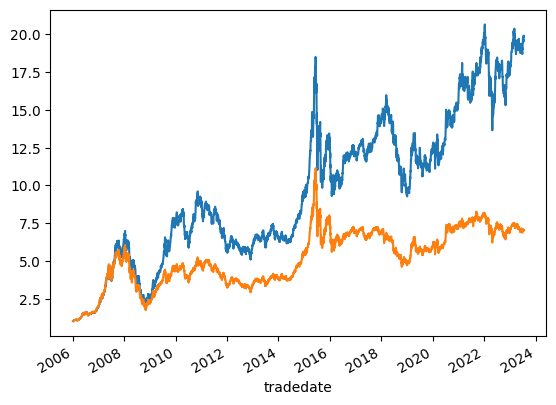

In [595]:
event_stg = (event_position*ret)[col_list].mean(axis=1).fillna(ret.mean(axis=1))
(event_stg+1).cumprod().plot()
(ret.mean(axis=1)+1).cumprod().plot()

stg_sharpe: 0.968126319648655
base_sharpe: 0.052852867304830985
stg_ann_ret: 0.04454146908529277
base_ann_ret: -0.011175120060185506


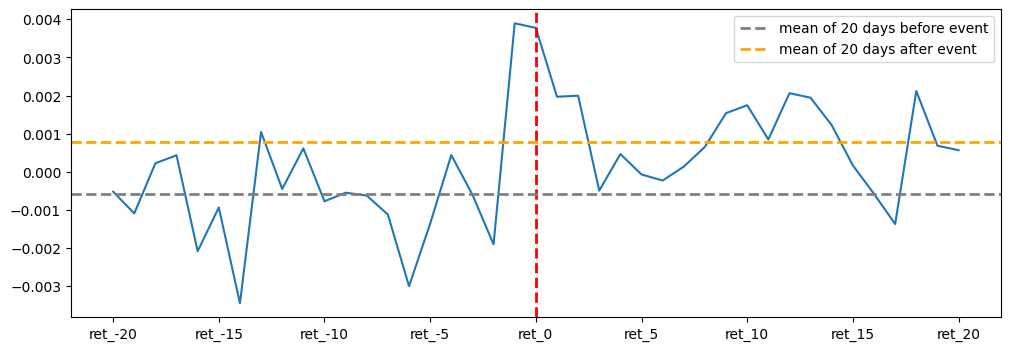

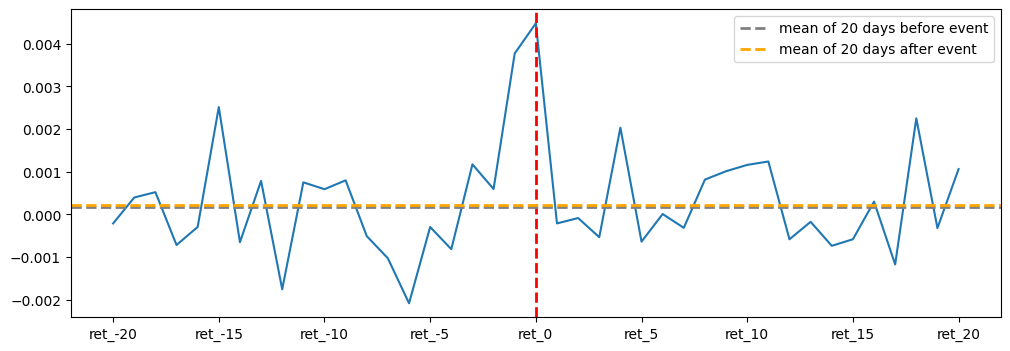

In [596]:
event_position = event_trigger.astype(int).replace({0:np.nan}).fillna(method='ffill',limit=5)

benchmark_ret = ret
event_stg = (event_position*ret).fillna(0).mean(axis=1)

start,end = '2016-01-01','2021-01-01'

stg_sharpe = empyrical.sharpe_ratio(event_stg[start:end],period='daily')
base_sharpe = empyrical.sharpe_ratio((benchmark_ret).mean(axis=1).fillna(0)[start:end],period='daily')

stg_ann_ret = empyrical.annual_return(event_stg[start:end],period='daily')
base_ann_ret = empyrical.annual_return((benchmark_ret).mean(axis=1).fillna(0)[start:end],period='daily')

print('stg_sharpe:',stg_sharpe)
print('base_sharpe:',base_sharpe)
print('stg_ann_ret:',stg_ann_ret)
print('base_ann_ret:',base_ann_ret)


plot_ret(events_ret_isp)

plot_ret(events_ret_oop)

In [597]:


stats_df = get_event_stats(events_cum_ret_isp)
display(stats_df)

stats_df = get_event_stats(events_cum_ret_oop)
display(stats_df)


my_corr_df = get_my_corr_df(pre_corr_isp, corr_isp, base_isp, pre_corr_oop, corr_oop, base_oop)

display(my_corr_df)


Signal count:  38.67741935483871
Signal frequency per year per sector:  2.15
Signal Interval per sector:  117.41


,before_ret,after_ret,diff,tval,long_win_ratio,short_win_ratio
1,0.0039,0.0020,-0.0019,-2.6146,0.5327,0.4526
5,-0.0067,0.0040,0.0107,7.3737,0.5666,0.4300
10,-0.0066,0.0078,0.0144,6.1855,0.5869,0.4131
20,-0.0233,0.0157,0.0389,13.5240,0.5497,0.4503
60,0.0304,0.0211,-0.0093,-1.5838,0.5474,0.4526


,before_ret,after_ret,diff,tval,long_win_ratio,short_win_ratio
1,0.0038,-0.0002,-0.0040,-2.9593,0.4760,0.5016
5,-0.0032,0.0005,0.0038,1.4706,0.4824,0.5176
10,0.0021,0.0031,0.0011,0.2921,0.5112,0.4888
20,-0.0154,0.0046,0.0200,3.0884,0.5048,0.4952
60,0.0066,0.0066,0.0001,0.0096,0.5048,0.4952


,pre_corr_isp,corr_isp,base_isp,pre_corr_oop,corr_oop,base_oop
corr,0.000603,0.038253,NaN,-0.005297,0.017829,NaN
ann_ret,0.003776,0.087954,-0.012055,0.025081,0.042160,-0.042936
sharpe,-0.019729,0.609104,0.041219,0.234413,0.321368,-0.079470
calmar,0.076725,0.387809,-0.000516,0.278965,0.390229,-0.095357
max_dd,-0.211503,-0.281919,-0.480105,-0.149745,-0.201182,-0.361962
win_ratio_day,0.464369,0.525750,0.511884,0.490299,0.512785,0.502162


In [392]:
from matplotlib import dates as mdates

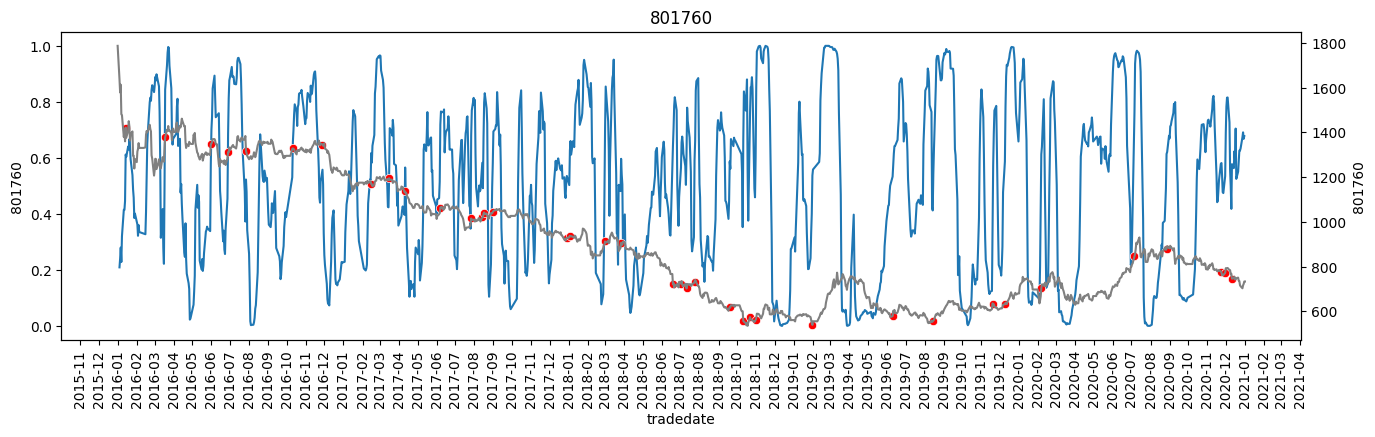

In [636]:
fig,ax = plt.subplots(figsize=(16,4))
pre_prices = (1+pre_ret).cumprod()

symbol = '801760'

start,end = '2016-01-01','2021-01-01'
# sns.lineplot(fast_ma[symbol][start:end],ax=ax)
# sns.lineplot(slow_ma[symbol][start:end],ax=ax)
sns.lineplot(dual_ma.rolling(252*5).rank(pct=True)[symbol][start:end],ax=ax)

# sns.lineplot(fast_ma.diff().rolling(252*5).rank(pct=True)[symbol][start:end],ax=ax)
# sns.lineplot(slow_ma.diff().rolling(252*3).rank(pct=True)[symbol][start:end],ax=ax)

ax2 = ax.twinx()

sns.lineplot(prices[symbol][start:end],ax=ax2,color='grey')
sns.scatterplot(event_trigger[symbol].astype(int).replace({0:np.nan})*prices[symbol][start:end],ax=ax2,color='red')



ax.set_title(symbol)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
# rotate x label 90
plt.setp(ax.get_xticklabels(), rotation=90);

# import mdates

In [248]:
rolling_prod = (1+ret).rolling(60).apply(lambda x:np.prod(x)-1)
rolling_prod = rolling_prod['2016-01-01':]
pd.concat([rolling_prod.idxmax(),rolling_prod.max()],axis=1).sort_index()

,0,1
symbol,,
801010,2019-04-25,0.578430
801030,2019-04-08,0.433113
801040,2021-09-09,0.566924
801050,2021-09-13,0.588681
801080,2020-02-25,0.507190
801110,2019-04-19,0.409436
801120,2020-07-14,0.458160
801130,2016-01-01,0.289894
801140,2019-04-04,0.374975


In [275]:
event_position = event_trigger.astype(int).replace({0:np.nan}).fillna(method='ffill',limit=5)
event_stg = (event_position*ret).fillna(0).mean(axis=1)['2016-01-01':]

<Axes: xlabel='tradedate'>

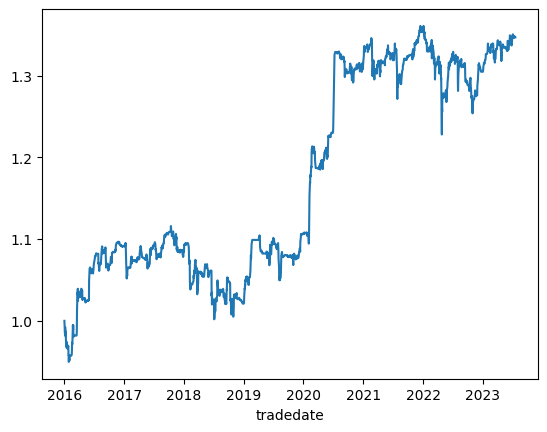

In [277]:
sns.lineplot((1+event_stg).cumprod())

<Axes: xlabel='tradedate'>

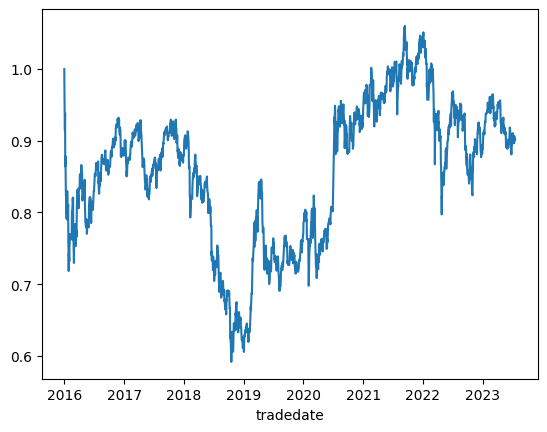

In [278]:
sns.lineplot((1+ret.mean(axis=1)['2016-01-01':]).cumprod())